# Testing

In [1]:
import numpy as np
import xarray as xr
import random
import matplotlib.pyplot as plt

#from cmethods.CMethods import CMethods
import sys

sys.path.append('../')
from cmethods.CMethods import CMethods
cm = CMethods()

np.random.seed(0)
random.seed(0)

In [2]:
obsh = xr.open_dataset('input_data/observations.nc')
simh = xr.open_dataset('input_data/control.nc')
simp = xr.open_dataset('input_data/scenario.nc')

In [13]:
def qm(ref,contr,scen,kind='+',n_quantiles = 100,detrended=False):
    obs, simh, simp = np.array(ref), np.array(contr), np.array(scen)
    
    global_max = max(np.amax(obs), np.amax(simh))
    global_min = min(np.amin(obs), np.amin(simh)) 
    wide = abs(global_max - global_min) / n_quantiles 
    xbins = np.arange(global_min, global_max + wide, wide)

    cdf_obs = cm.get_cdf(obs, xbins)
    cdf_simh = cm.get_cdf(simh, xbins)
    res = scen.copy(deep=True)
    
    #simh_mean = np.nanmean(simh)
    
    if detrended or kind == '*':    
        for month, idxs in scen.groupby('time.month').groups.items():
            m_simh, m_simp = [], []
            for idx in idxs:
                m_simh.append(simh[idx])
                m_simp.append(simp[idx])
            
            m_simh = np.array(m_simh)
            m_simp = np.array(m_simp)
            m_simh_mean = np.nanmean(m_simh)     
            m_simp_mean = np.nanmean(m_simp) 
            
            if kind == '+':
                epsilon = np.interp(m_simp - m_simp_mean + m_simh_mean, xbins, cdf_simh)
                x = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) + m_simp_mean - m_simh_mean
            else: 
                epsilon = np.interp((m_simh_mean * m_simp) / m_simp_mean, xbins, cdf_simh, left=.0, right=999.0)
                x = np.interp(epsilon, cdf_obs, xbins, left=.0, right=999.9) * (m_simp_mean / m_simh_mean) 
                #x = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) * (m_simp_mean / m_simh_mean)
            for i, idx in enumerate(idxs): res.values[idx] = x[i]
        return res
    else: # additive, no detrend 
        epsilon = np.interp(simp, xbins, cdf_simh)                                 # Eq. 1            
        res.values = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins)
        return res
x = qm(
    obsh['tas'][:,0,0],
    simh['tas'][:,0,0],
    simp['tas'][:,0,0],
    kind='+',
    detrended=True
)

In [16]:
x = cm.quantile_mapping(
    obsh['tas'][:,0,0],
    simh['tas'][:,0,0],
    simp['tas'][:,0,0],
    kind='+',
    detrended=False,
    n_quantiles =100
)

In [17]:
x

<xarray.DataArray 'tas' (time: 10950)>
array([-23.09702246, -23.43043166, -23.18123773, ..., -25.55749701,
       -26.33149977, -25.62459499])
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2030-12-31 00:00:00
    lat      int64 23
    lon      int64 0
Attributes:
    units:    °C

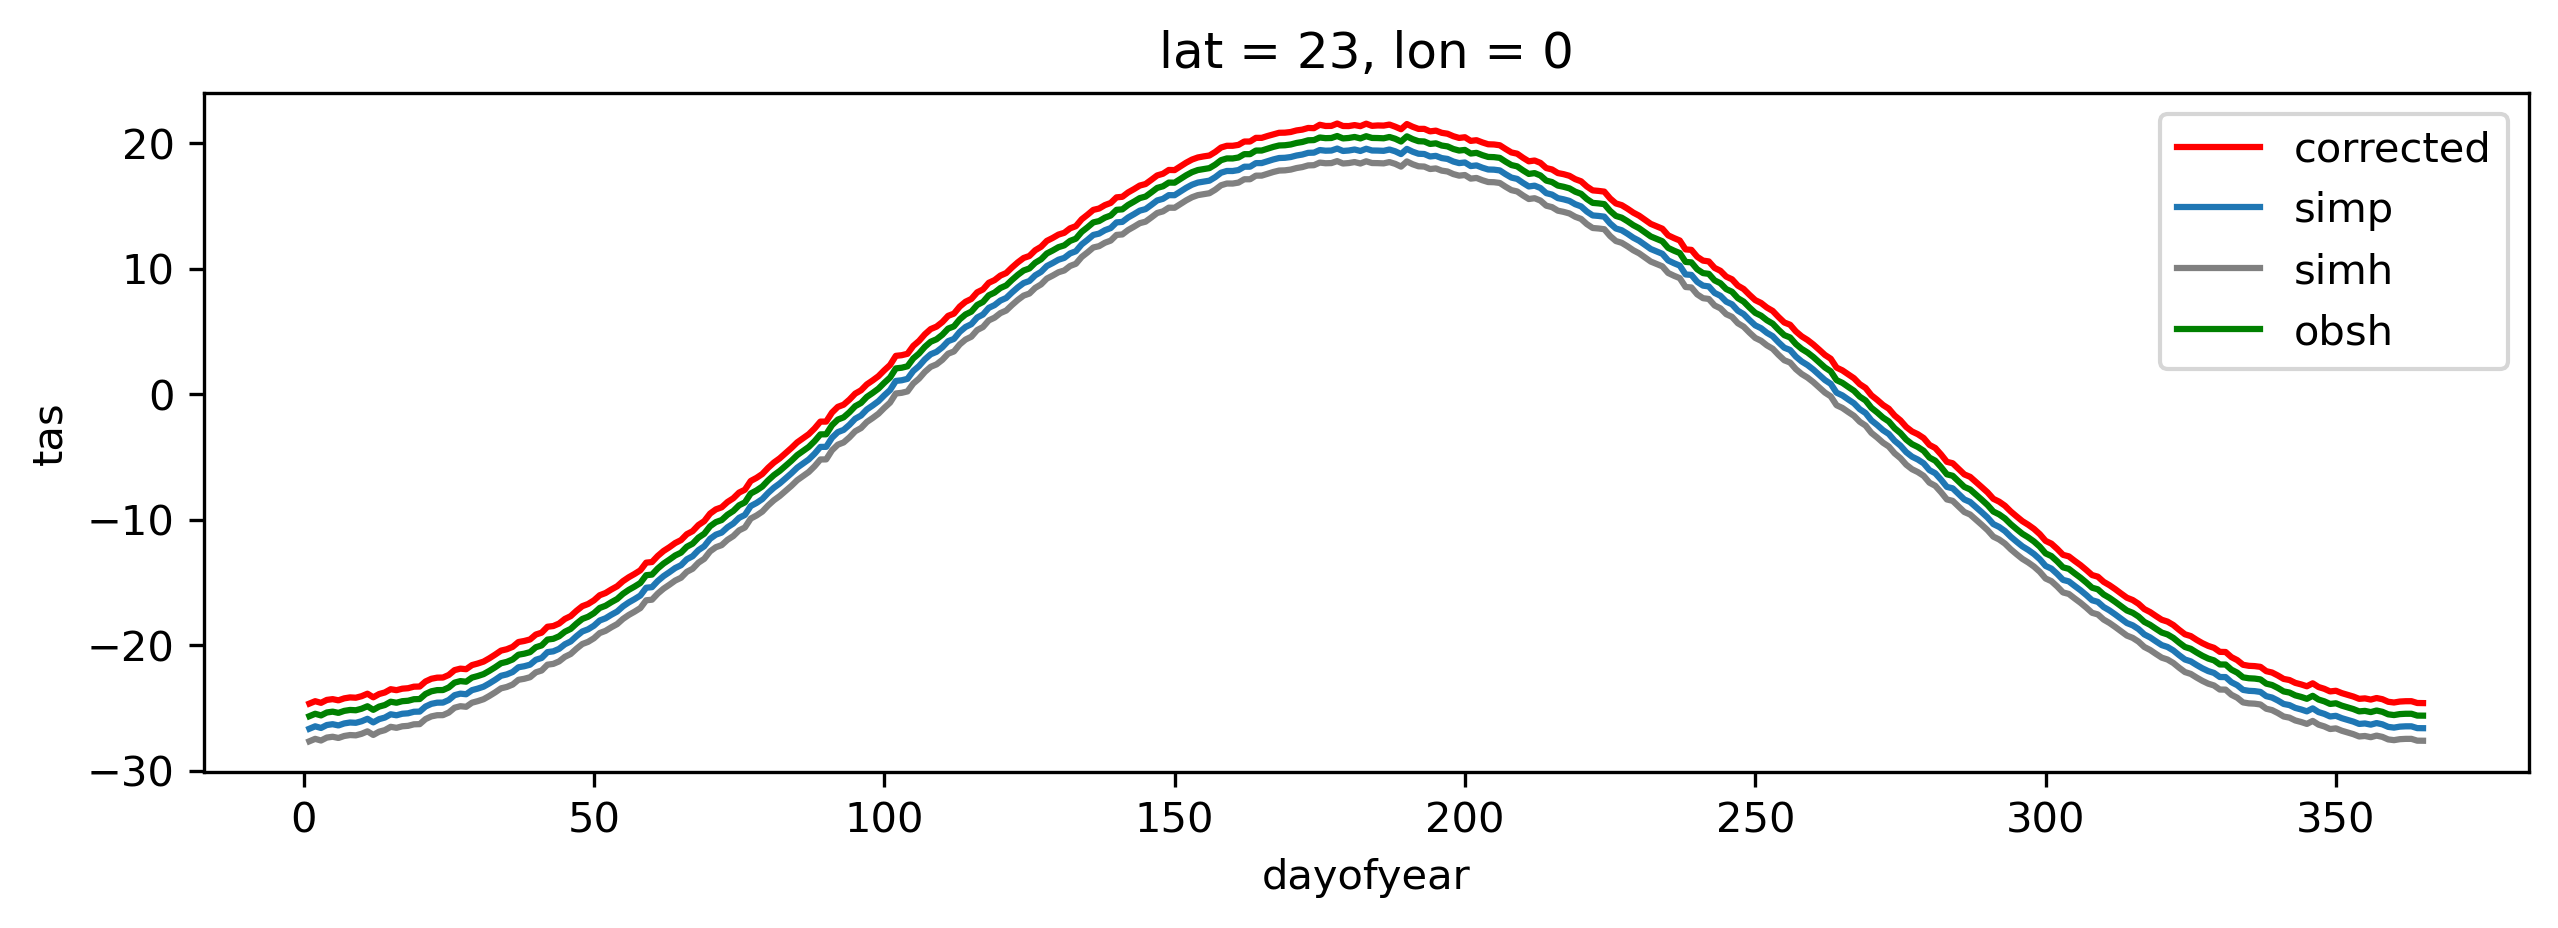

In [18]:
plt.figure(figsize=(10,3),dpi=300)
x.groupby('time.dayofyear').mean(...).plot(label="corrected", color='red')
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='simp', color='C0')
simh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='simh', color='grey')
obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='obsh', color='green')
plt.legend()

In [36]:
def dqm(obs,simh,simp,kind='+',n_quantiles=100,detrended=False,**kwargs):
    res = simp.copy(deep=True)
    obs, simh, simp = np.sort(obs), np.sort(simh), np.array(simp)
    global_max = max(np.amax(obs), np.amax(simh))
    wide = global_max / n_quantiles
    xbins = np.arange(0.0, global_max + wide, wide)

    cdf_obs = cm.get_cdf(obs, xbins)
    cdf_simh = cm.get_cdf(simh, xbins)
    
    simh_mean = np.nanmean(simh)
    simp_mean = np.nanmean(simp)
    
    if kind == '*':
        epsilon = np.interp(( simh_mean * simp ) / simp_mean, xbins, cdf_obs)                                  
        res.values = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) * (simp_mean)  / simh_mean
    elif kind == '+':
        epsilon = np.interp((simp - simp_mean) + simh_mean, xbins, cdf_simh)
        res.values = (cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) - simh_mean) + simp_mean 
    return res
    '''
    
    if kwargs.get('detrended', False):
        for month, idxs in res.groupby('time.month').groups.items():
            m_simh, m_simp = [], []
            for idx in idxs:
                m_simh.append(simh[idx])
                m_simp.append(simp[idx])

            m_simh_mean = np.nanmean(m_simh)
            m_simp_mean = np.nanmean(m_simp)            
            
            
            epsilon = np.interp((m_simp - m_simp_mean) + m_simh_mean, xbins, cdf_simh)
            X = (cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) + m_simp_mean) - m_simh_mean
            for i, idx in enumerate(idxs): res.values[idx] = X[i]
    else:
        epsilon = np.interp(simp, xbins, cdf_simh, left=0.0, right=999.0)
        res.values = np.interp(epsilon, cdf_obs, xbins, left=0.0, right=-999.0)
    return res
    '''
x = dqm(
    obsh['tas'][:,0,0],
    simh['tas'][:,0,0],
    simp['tas'][:,0,0]
)

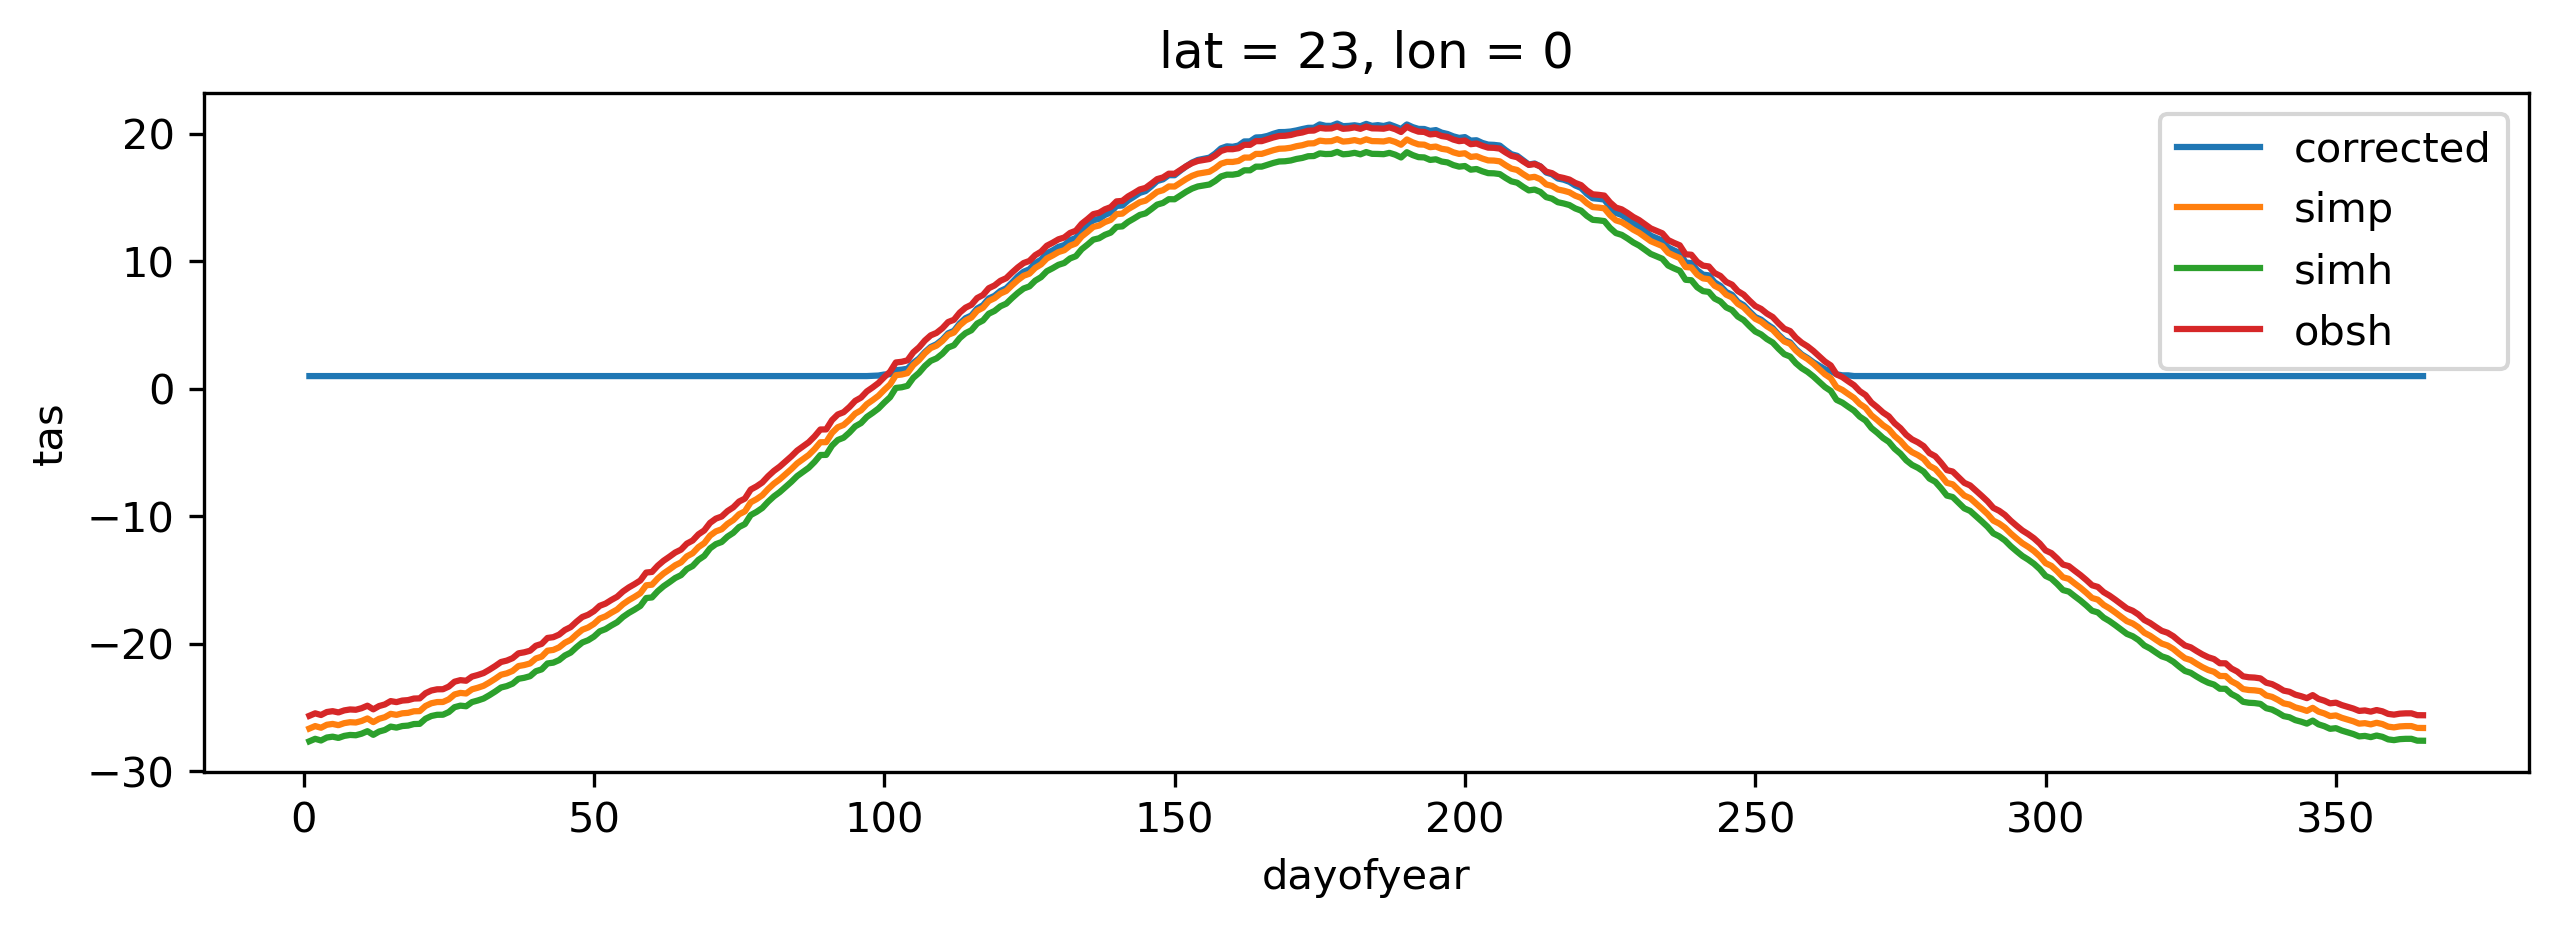

In [37]:
plt.figure(figsize=(10,3),dpi=300)
x.groupby('time.dayofyear').mean(...).plot(label="corrected")
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='simp')

simh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='simh')

obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='obsh')
plt.legend()

In [177]:
def qm(ref,contr,scen,n_quantiles = 100,detrended=False):
    obs, simh, simp = np.array(ref), np.array(contr), np.array(scen)
    
    global_max = max(np.amax(obs), np.amax(simh))
    global_min = min(np.amin(obs), np.amin(simh)) 
    wide = abs(global_max - global_min) / n_quantiles 
    xbins = np.arange(global_min, global_max + wide, wide)

    cdf_obs = cm.get_cdf(obs, xbins)
    cdf_simh = cm.get_cdf(simh, xbins)
    res = scen.copy(deep=True)
    
    if detrended:    
        for month, idxs in scen.groupby('time.month').groups.items():
            m_simh, m_simp = [], []
            for idx in idxs:
                m_simh.append(simh[idx])
                m_simp.append(simp[idx])
            
            m_simh_mean = np.nanmean(m_simh)     
            m_simp_mean = np.nanmean(m_simp) 

            epsilon = np.interp(m_simp - m_simp_mean + m_simh_mean, xbins, cdf_simh)
            x = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) + m_simp_mean - m_simh_mean
            for i, idx in enumerate(idxs): res.values[idx] = x[i]
        return res
    else:    
        epsilon = np.interp(simp, xbins, cdf_simh)                                 # Eq. 1            
        res.values = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins)
        return res

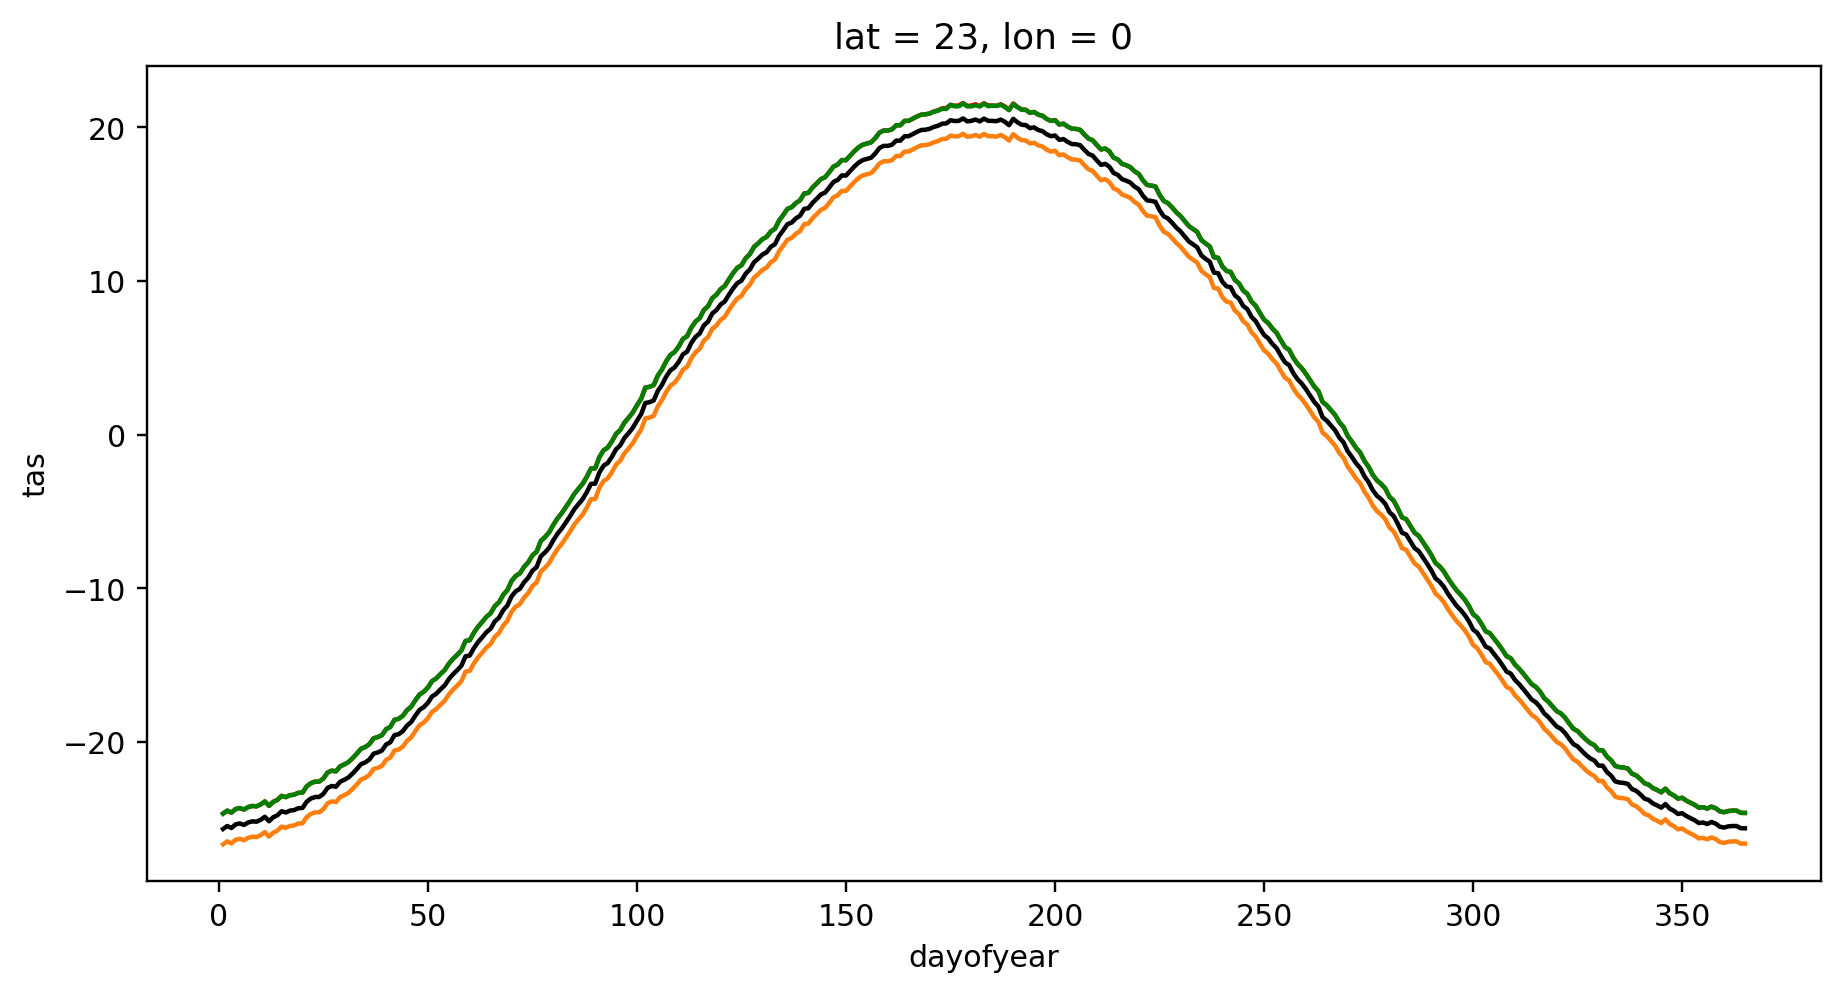

In [178]:
res = qm(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000,
    detrended=True
)
res2 = qm(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000,
    detrended=False
)
plt.figure(figsize=(10,5),dpi=216)
res.groupby('time.dayofyear').mean(...).plot(color='red')
res2.groupby('time.dayofyear').mean(...).plot(color='green')
obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='black')
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='C1')

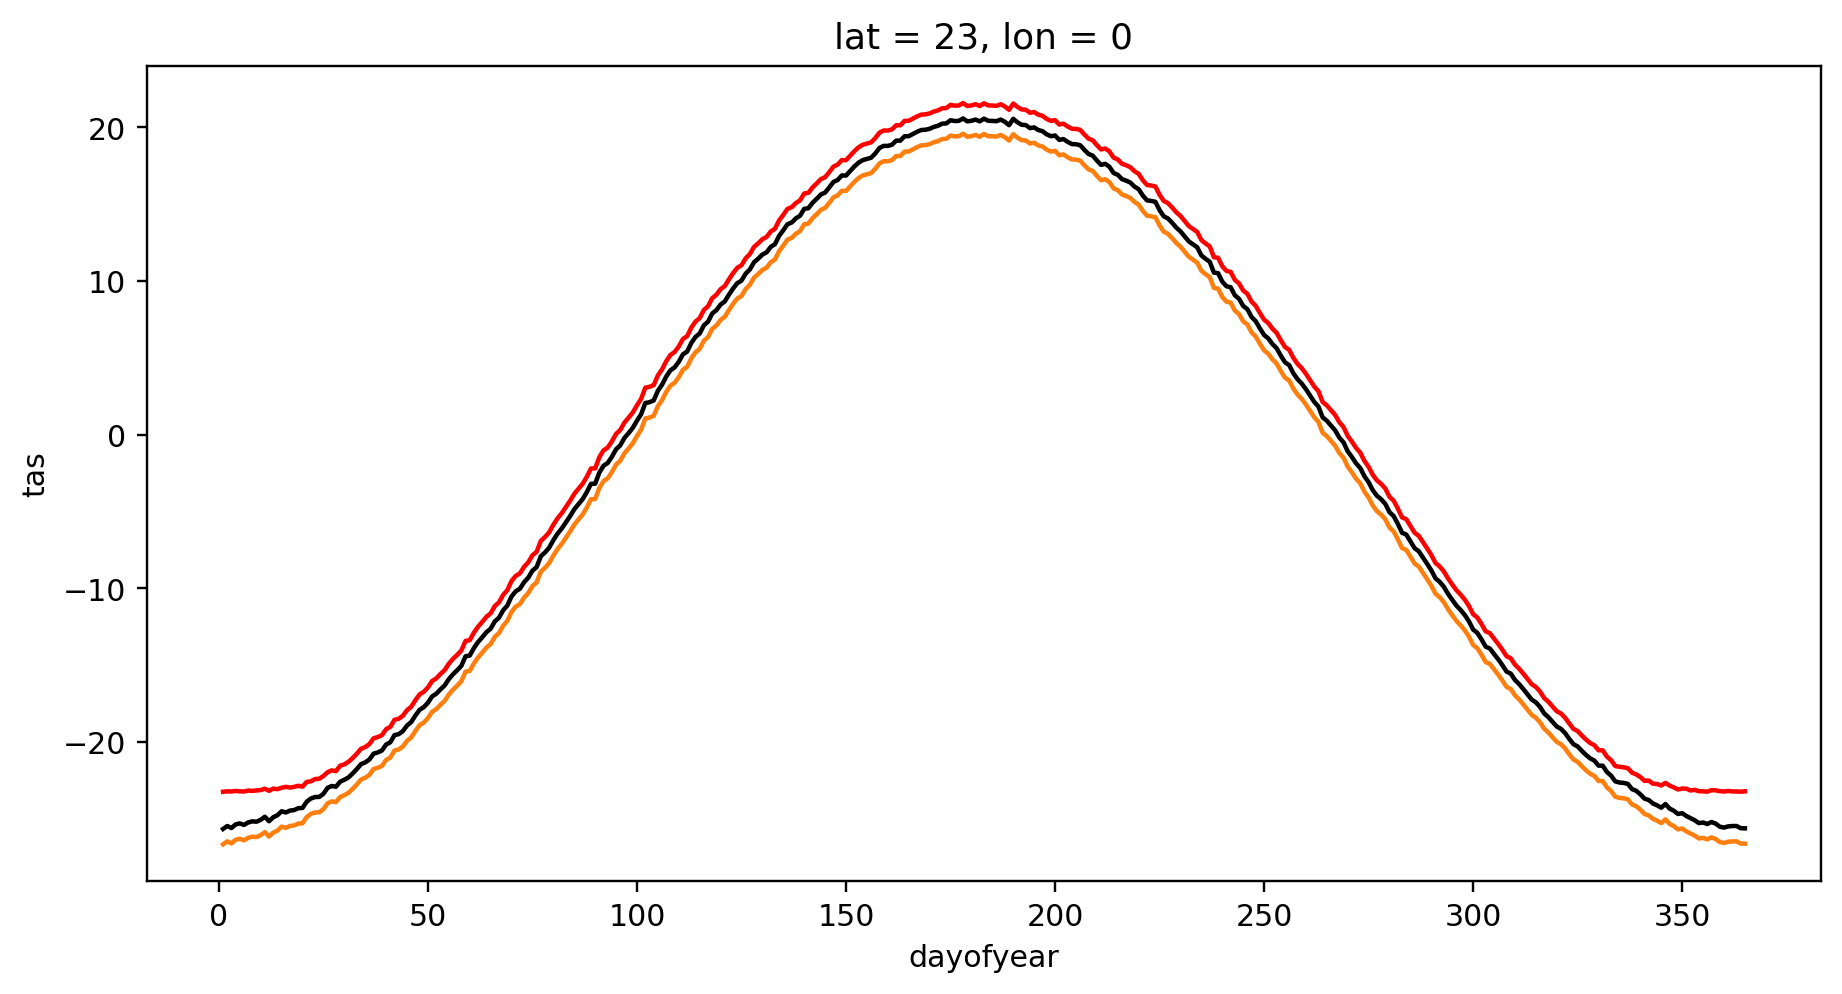

In [119]:
res = simp['tas'][:,0,0].copy(deep=True)
res.values = qm(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000,
    detrended=True
)

plt.figure(figsize=(10,5),dpi=216)
res.groupby('time.dayofyear').mean(...).plot(color='red')
obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='black')
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='C1')